# Kirk Evaluation Protocol 2.0
First, generate train and test contexts.
Then run commands down below.

## Create Train/Test Contexts

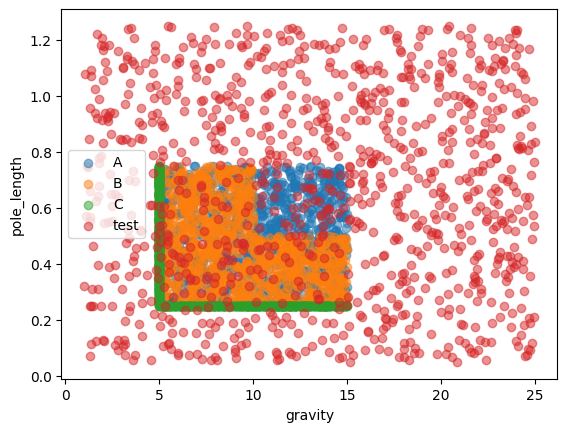

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from experiments.common.utils.json_utils import lazy_json_dump

 
env_name = "CARLCartPoleEnv"
seed = 6847
n_samples_train = 1000
n_samples_test = 1000

bounds = {
    "gravity": {
        "train": [5, 15],
        "test": [1, 25]
    },
    "pole_length": {
        "train": [0.25, 0.75],
        "test": [0.05, 1.25],
    }
}

outdir = Path("data/kirk_ep") / env_name
outdir.mkdir(exist_ok=True, parents=True)


def get_contexts(bounds: dict[str, dict[str, list[float]]], mode: str = "A", seed: int = None) -> tuple[dict, np.ndarray]:

    # Create train context set
    rng = np.random.default_rng(seed=seed)
    B = np.array([b["train"] for cf, b in bounds.items()])
    cfs = list(bounds.keys())
    contexts = {}
    if mode == "A":
        X = np.array([rng.uniform(*B[i], size=n_samples_train) for i in range(len(B))])
    elif mode == "B":
        n = n_samples_train // 3
        n2 = n_samples_train - n

        B_ = B.copy()
        B_[1, 1] = np.mean(B_[1])   
        x1 =  np.array([rng.uniform(*B_[i], size=n2) for i in range(len(B))])

        B_ = B.copy()
        B_[0, 1] = np.mean(B_[0])
        B_[1, 0] = np.mean(B_[1])
        x2 = np.array([rng.uniform(*B_[i], size=n) for i in range(len(B))])

        X = np.concatenate([x1, x2], axis=1)
    elif mode == "C":
        n = n_samples_train // 2

        X = []
        for i in range(len(B)):
            B_ = B.copy()
            B_[i, 1] = B_[i, 0]
            x =  np.array([rng.uniform(*B_[i], size=n) for i in range(len(B))])
            X.append(x)

        X = np.concatenate(X, axis=1)

    elif mode == "test":
        B = np.array([b["test"] for cf, b in bounds.items()])
        X = np.array([rng.uniform(*B[i], size=n_samples_train) for i in range(len(B))])

    else:
        raise NotImplementedError

    contexts = {i: {cf: X[j,i] for j, cf in enumerate(cfs)} for i in range(X.shape[1])}  

    return contexts, X

modes = ["A", "B", "C", "test"]


for mode in modes:
    contexts, X = get_contexts(bounds=bounds, mode=mode, seed=seed)

    lazy_json_dump(contexts, outdir / f"contexts_{mode}.json")

    plt.scatter(*X, label=mode, alpha=0.5)


plt.legend()

cfs = list(bounds.keys())
plt.xlabel(cfs[0])
plt.ylabel(cfs[1])
plt.show()




## Command

Run:
`python experiments/benchmarking/run_training.py +experiments=kirk_ep +experiments/ep/mode=A,B,C 'seed=range(1,11)' '+context_visibility=hidden,visible_all,cgate_hadamard' -m `

More env steps, less visibilities, cpu normal:
`python experiments/benchmarking/run_training.py +experiments=kirk_ep max_num_frames=500000 +slurm=cpu hydra.launcher.timeout_min=300 +experiments/ep/mode=A,B,C 'seed=range(1,11)' '+context_visibility=hidden,visible_all' -m`

Evaluate:
`python experiments/evaluation/run_evaluation.py 'n_eval_episodes_per_context=5' 'experiment=kirk_eval_ep' 'contexts_path=/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/experiments/evaluation/data/kirk_ep/CARLCartPoleEnv/contexts_test.json' -m --result_dir '/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-02-17/07-52-33_benchmark_train'`

## Load Eval Data

In [2]:
folders_eval = [
    # "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-17/13-25-22"  # eval on train  DONT USE BOTH CANT DIFFERENTIATE
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-20/09-52-51",  # eval on test, 100k training steps
]

import pandas as pd
import experiments.evaluation.loading
from importlib import reload
reload(experiments.evaluation.loading)


rpc_fn = outdir / "rpc.csv"
reload = True

df = pd.concat([experiments.evaluation.loading.load(folder_eval=folder_eval, rpc_fn=rpc_fn, load_from_path=experiments.evaluation.loading.load_from_path_eval, reload_rpc=reload) for folder_eval in folders_eval]).reset_index(drop=True)


from rich import print as printr

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Discretize Context Features

In [17]:
cfs = list(bounds.keys())
n_bins = 20
cf_bins = {}
for cf in cfs:
    precision = 3
    if cf == "gravity":
        precision = 1
    bin_idx, bins = pd.cut(df[cf], bins=n_bins, include_lowest=True, retbins=True, labels=False)
    labels, bins = pd.cut(df[cf], bins=n_bins, include_lowest=True, retbins=True, precision=precision)
    cf_bins[cf] = bins
    df[cf + "_bin_idx"] = bin_idx
    df[cf + "_bin_lbl"] = labels

    


## Plot Heatmaps

hidden
hidden
hidden


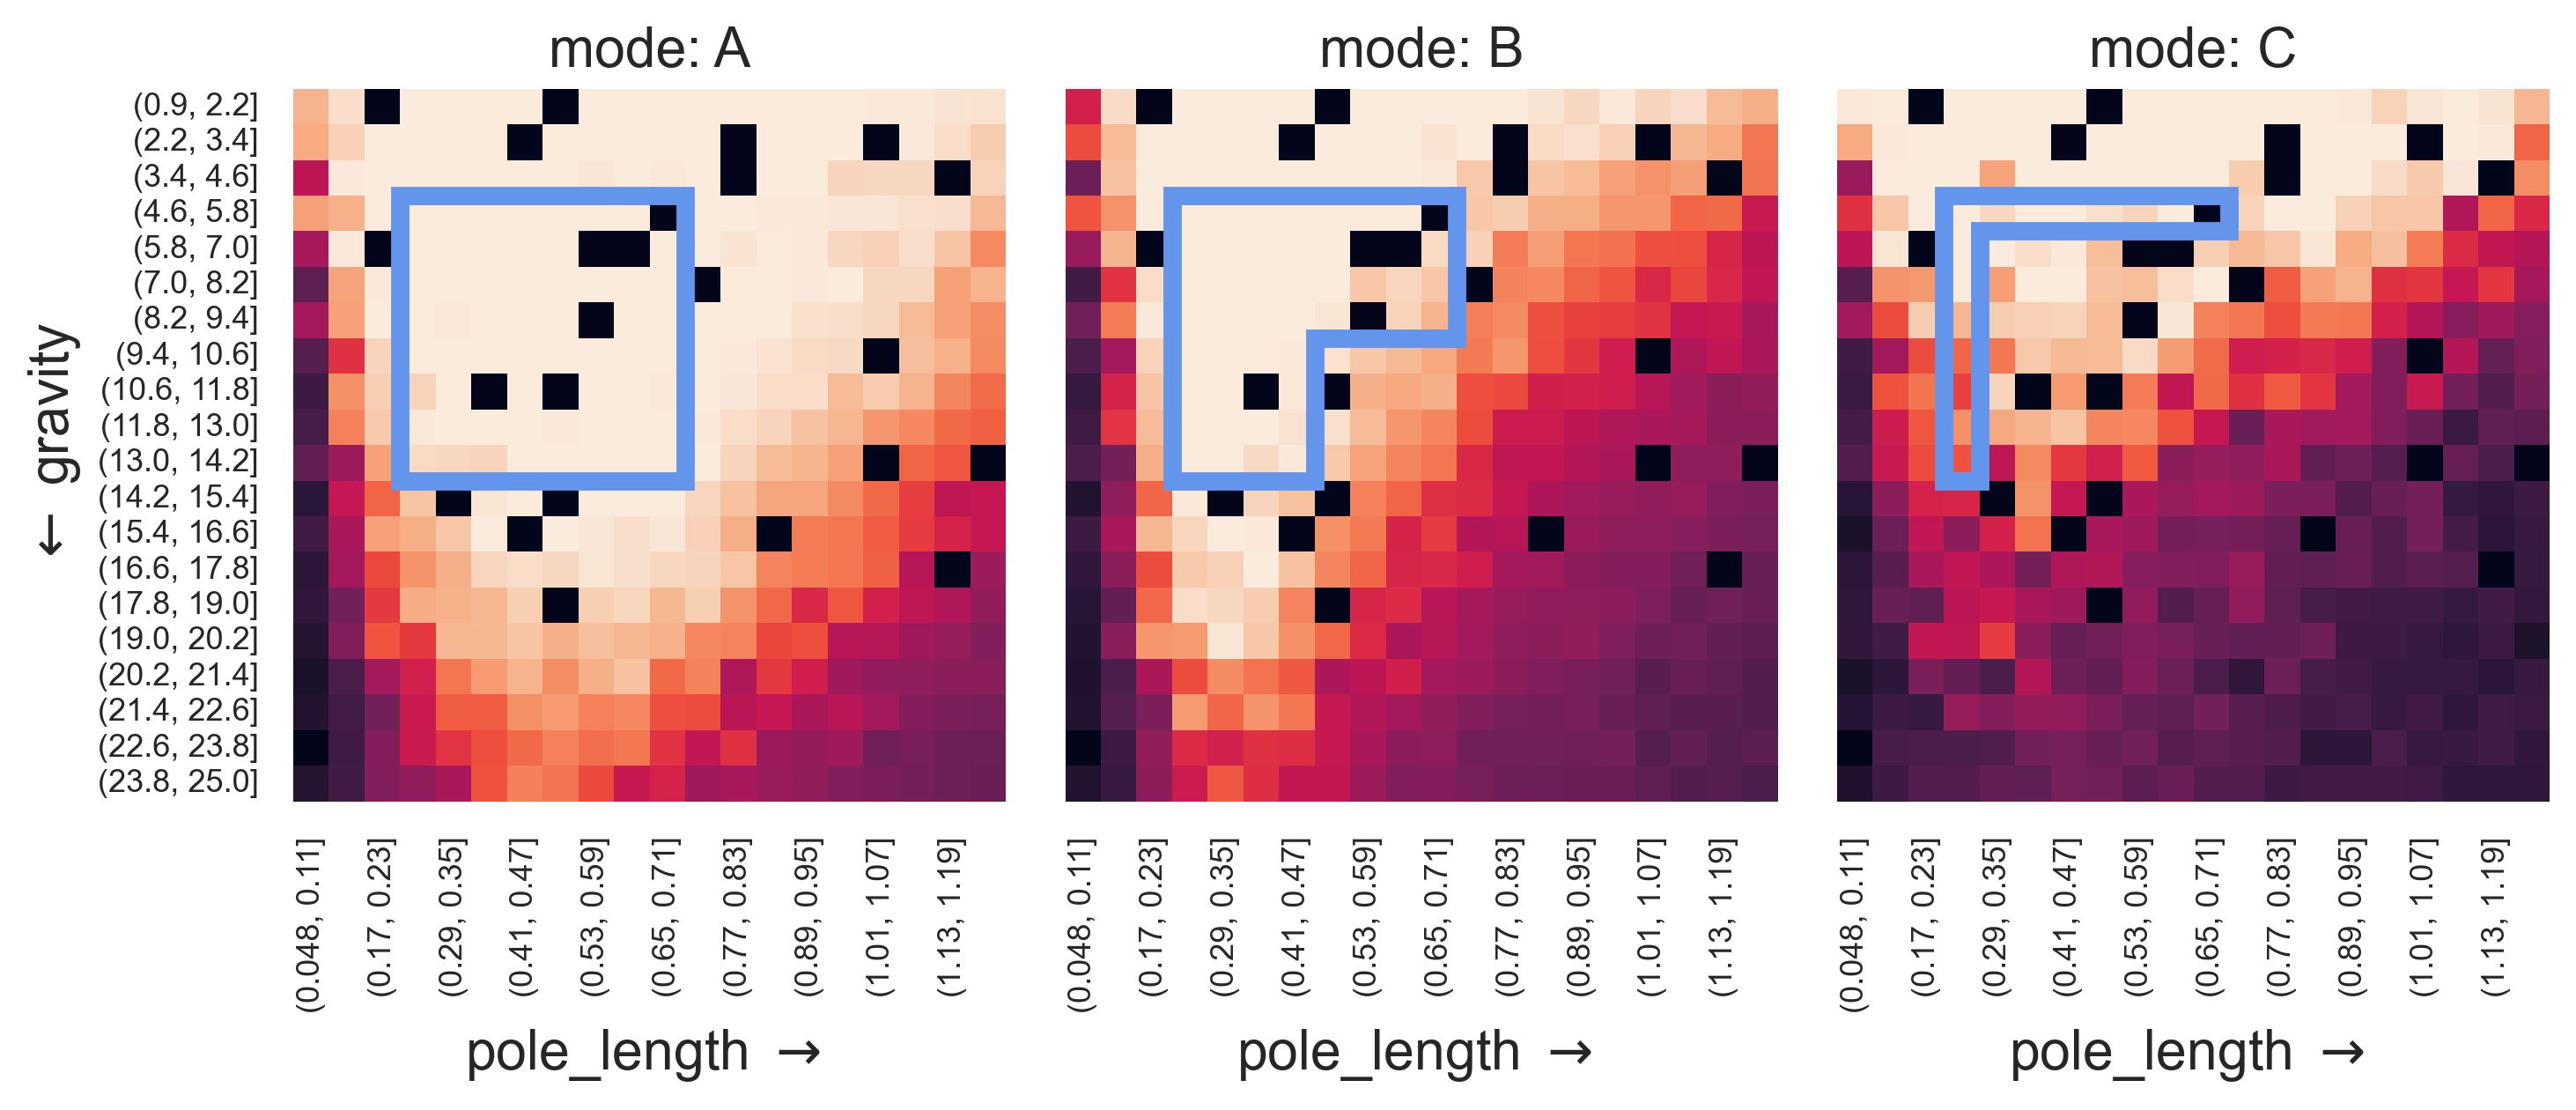

concat (all)
concat (all)
concat (all)


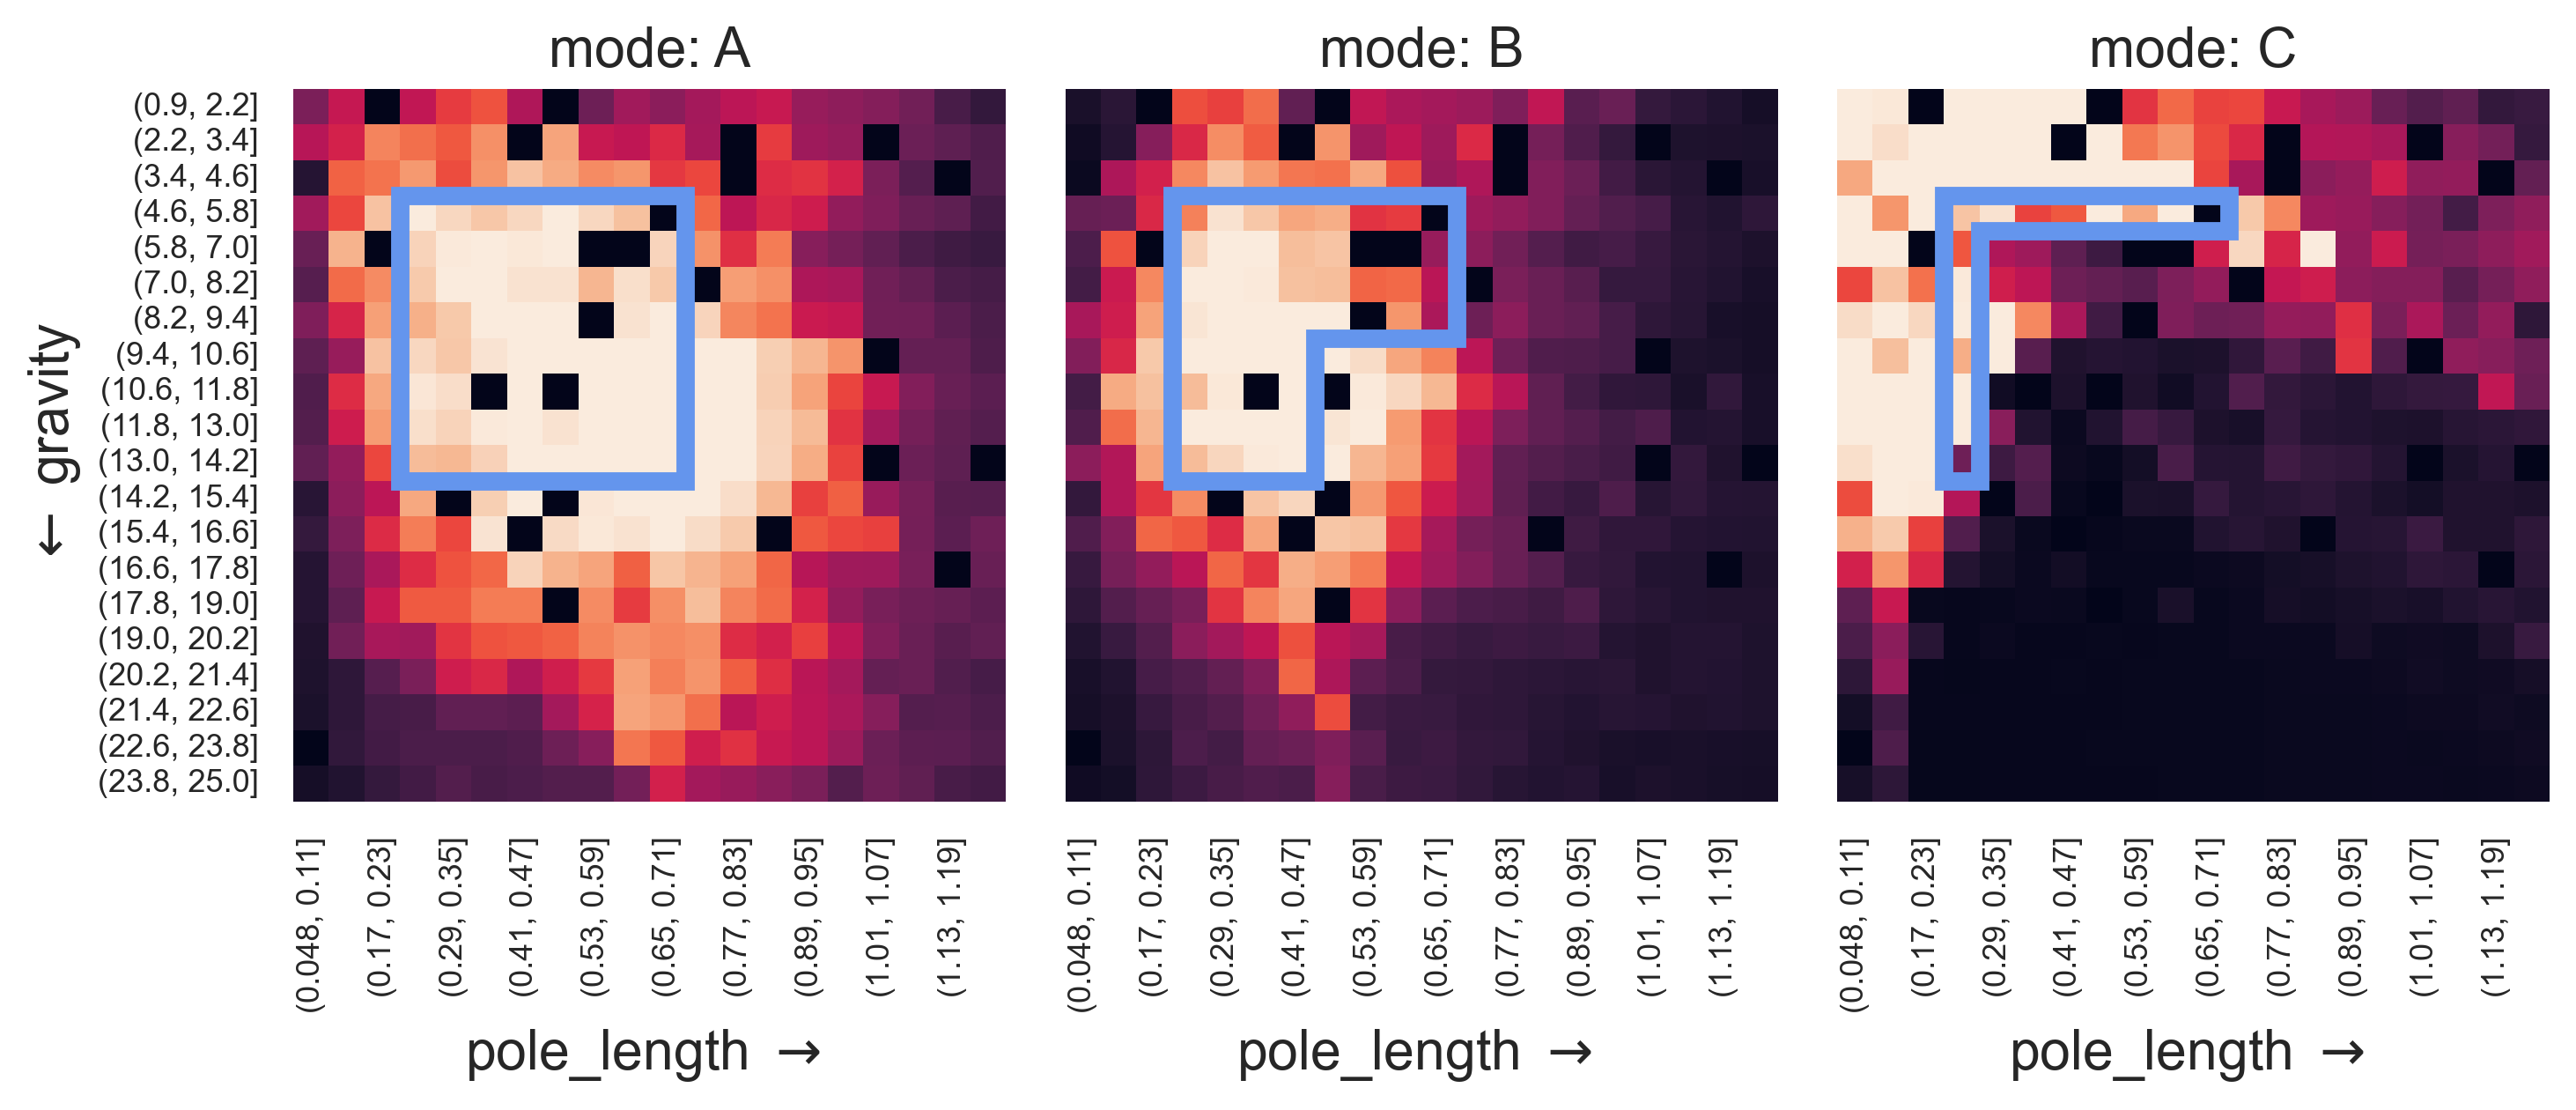

cgate_hadamard
cgate_hadamard
cgate_hadamard


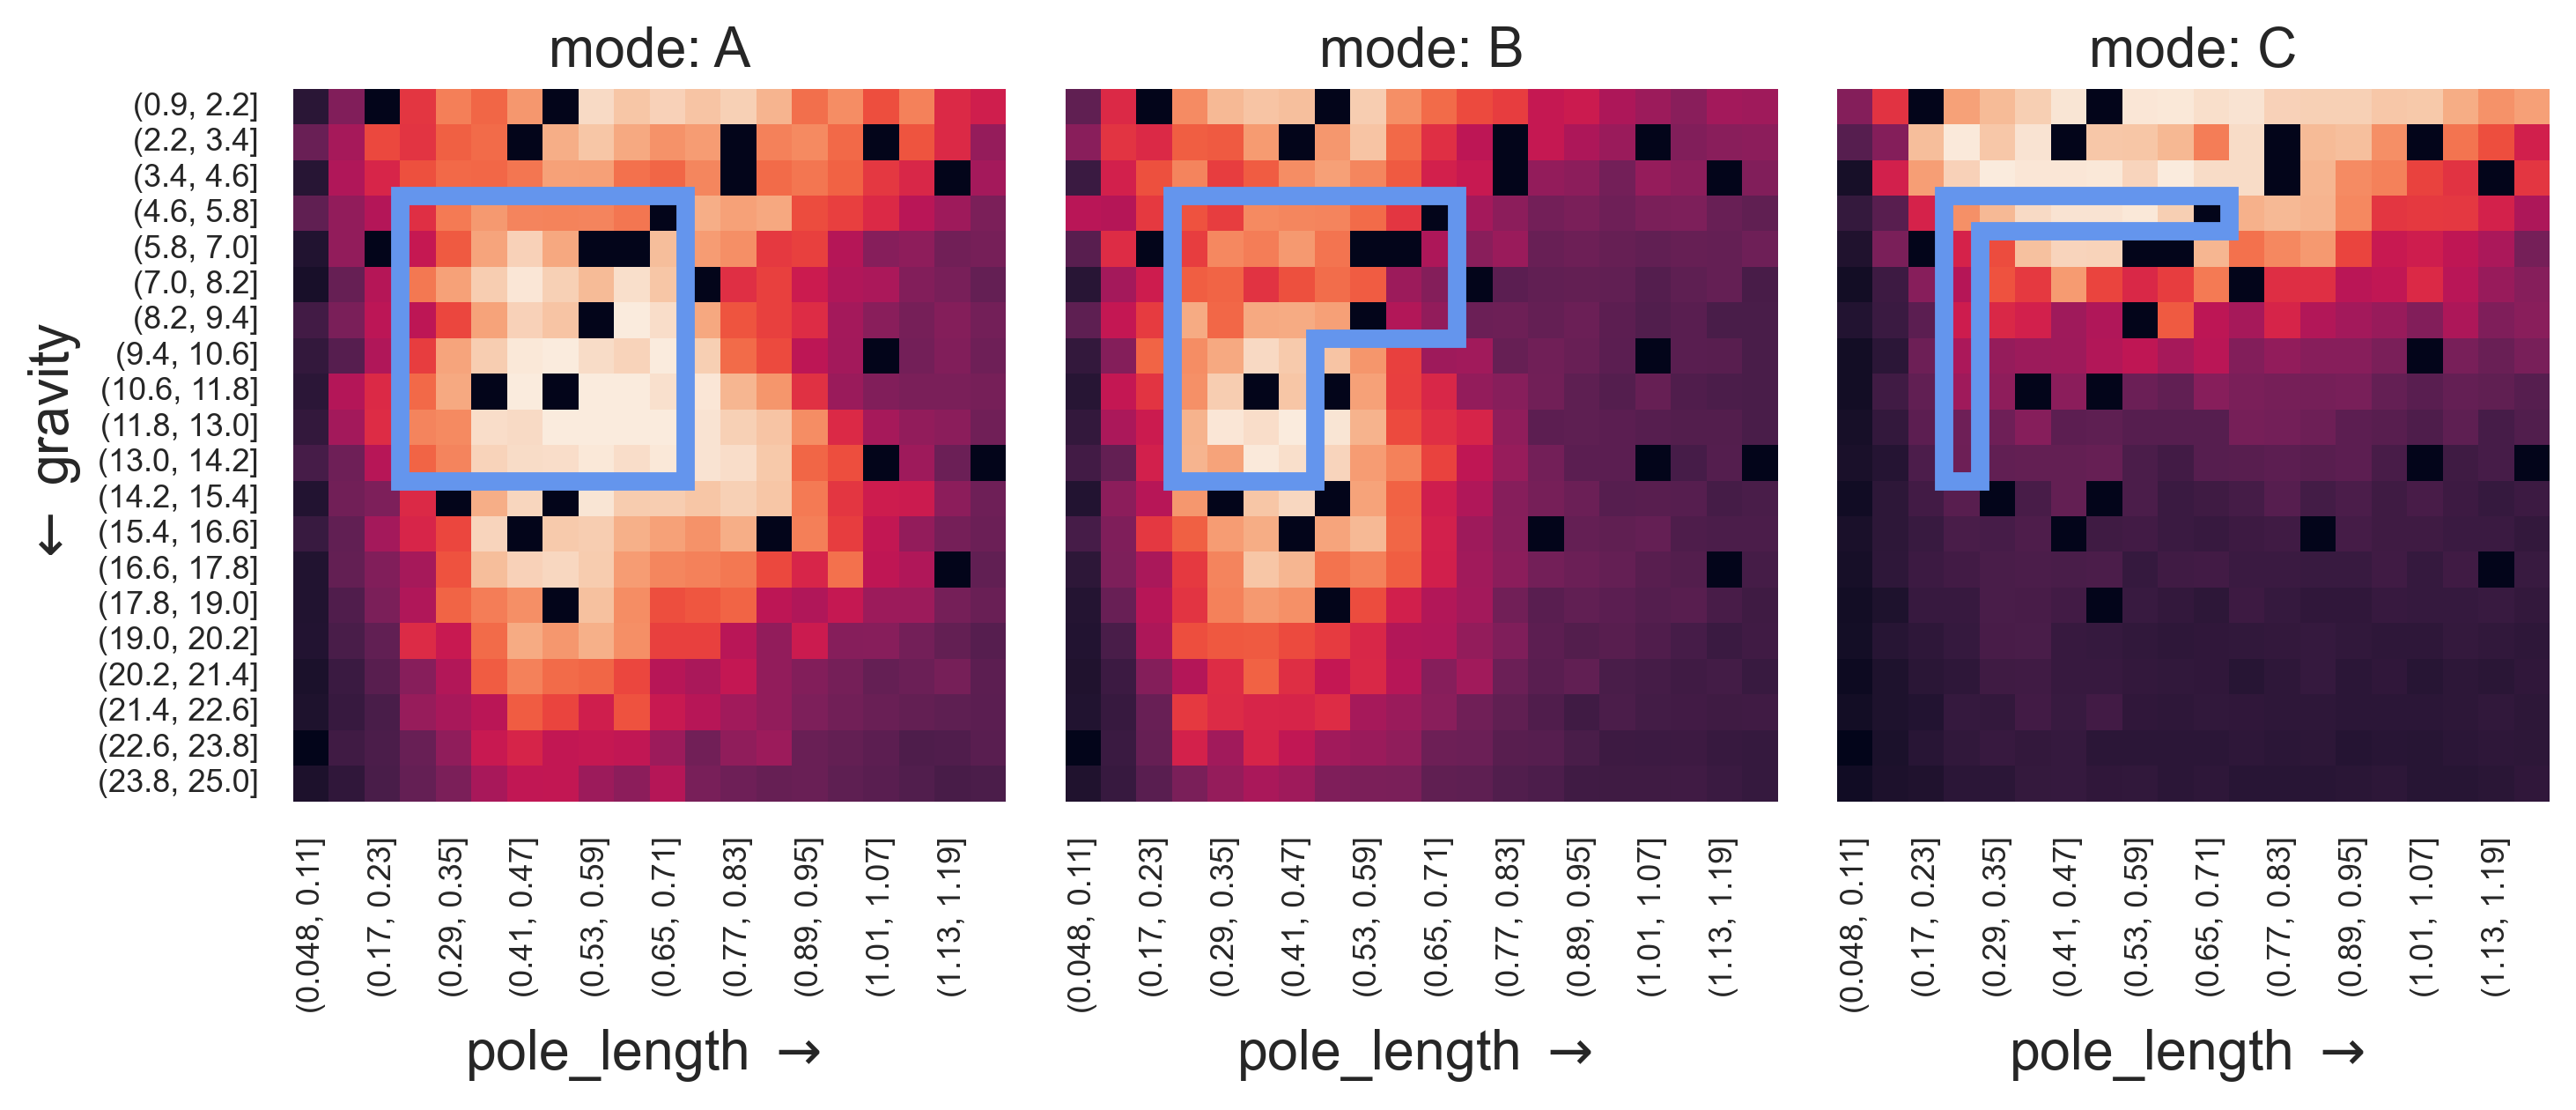

In [24]:
from scipy.stats import trim_mean
import seaborn as sns
from matplotlib.patches import Rectangle, Polygon, PathPatch
import matplotlib as mpl


sns.set(font_scale=1.25)
sns.set_style("whitegrid")

visibilities = list(df["visibility"].unique())
modes = list(df["mode"].unique())
hm_long = df.groupby(by=[cf + "_bin_idx" for cf in cfs]+ ["visibility", "mode"]).apply(lambda x: trim_mean(x["return"], proportiontocut=0.25))

heatmap = np.zeros((n_bins, n_bins, len(visibilities), len(modes)))
for idx in hm_long.index:
    i, j, v, m = idx
    v = visibilities.index(v)
    m = modes.index(m)
    # if i == 0 and j == 1:
    #     print(visibilities[v], modes[m], hm_long[idx])
    heatmap[i, j, v, m] = hm_long[idx]

xbinlabels = list(df[cfs[1] + "_bin_lbl"].unique())
ybinlabels = list(df[cfs[0] + "_bin_lbl"].unique())

xlabel = cfs[1]  # col
ylabel = cfs[0]  # row

xbounds = bounds[cfs[1]]["train"]
ybounds = bounds[cfs[0]]["train"]

vlines = [xbounds[0], np.mean(xbounds), xbounds[1]]
hlines = [ybounds[0], np.mean(ybounds), ybounds[1]]

vlines = pd.cut(vlines, bins=cf_bins[cfs[1]], include_lowest=True, retbins=False, labels=False)
hlines = pd.cut(hlines, bins=cf_bins[cfs[0]], include_lowest=True, retbins=False, labels=False)

xbinlabels.sort()
ybinlabels.sort()

patch_kwargs = {"fill": False, "linewidth": 5, "color": "cornflowerblue"}


for v in range(heatmap.shape[-2]):
    fig = plt.figure(figsize=(10, 8), dpi=300)
    axes = fig.subplots(nrows=1, ncols=len(modes))
    for m in range(heatmap.shape[-1]):
        mode = modes[m]
        
        V = vlines
        H = hlines
        if modes[m] == "A":
            polygon = np.array([
                [H[0], V[0]],
                [H[0], V[2]],
                [H[2], V[2]],
                [H[2], V[0]],
            ])
            patch = Polygon(xy=polygon, **patch_kwargs)
        elif modes[m] == "B":
            polygon = np.array([
                [H[0], V[0]],
                [H[0], V[2]],
                [H[1], V[2]],
                [H[1], V[1]],
                [H[2], V[1]],
                [H[2], V[0]],
            ])
            patch = Polygon(xy=polygon, **patch_kwargs)
        elif modes[m] == "C":
            polygon = np.array([
                [H[2], V[0]],
                [H[0], V[0]],
                [H[0], V[2]],
                # [H[0], V[0]],
                # [H[2], V[0]],
                [H[0] + 1, V[2]],
                [H[0] + 1, V[0] + 1],
                [H[2], V[0] + 1],
            ])
            patch = Polygon(xy=polygon, **patch_kwargs)
        else:
            patch = None

        X = heatmap[:, :, v, m]
        ax = axes[m]
        ax = sns.heatmap(data=X, vmin=0, vmax=500, annot=False, fmt=".0f", annot_kws=dict(fontsize='xx-small'), ax=ax, cbar=False) #  cbar=True if m==len(modes) - 1 else False)

        vis = visibilities[v]
        mode = modes[m]
        print(vis)
        ax.set_title(f"mode: {mode}")

        xticklabels = np.array([str(x) for x in xbinlabels])
        ids = [int(xl.get_text()) for xl in ax.get_xticklabels()]
        ax.set_xticklabels(list(xticklabels[ids]), fontsize='xx-small', rotation=90)

        
        if m == 0:
            ax.set_ylabel(r"$\leftarrow$ " + ylabel)

            yticklabels = np.array([str(x) for x in ybinlabels])
            ids = [int(xl.get_text()) for xl in ax.get_yticklabels()]
            ax.set_yticklabels(list(yticklabels[ids]), fontsize='xx-small', rotation=0)
        else:
            ax.set_ylabel(None)
            ax.set_yticklabels(["" for y in ybinlabels])
        ax.set_xlabel(xlabel + r" $\rightarrow$ ")
        
        # ax.vlines(vlines, 0, X.shape[0], color="black")
        # ax.hlines(hlines, 0, X.shape[1], color="black")
        ax.set_aspect("equal")

        ax.add_patch(patch)
        
    fig.set_tight_layout(True)
    fig_fn = outdir / f"heatmap_{vis}.pdf"
    fig.savefig(fig_fn, bbox_inches="tight", dpi=300)
    plt.show()


    # Plot cbar
    import matplotlib.pyplot as plt







## Plot Colorbar

/tmp/ipykernel_10917/4155390871.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(fig_fn, bbox_inches="tight", dpi=300)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


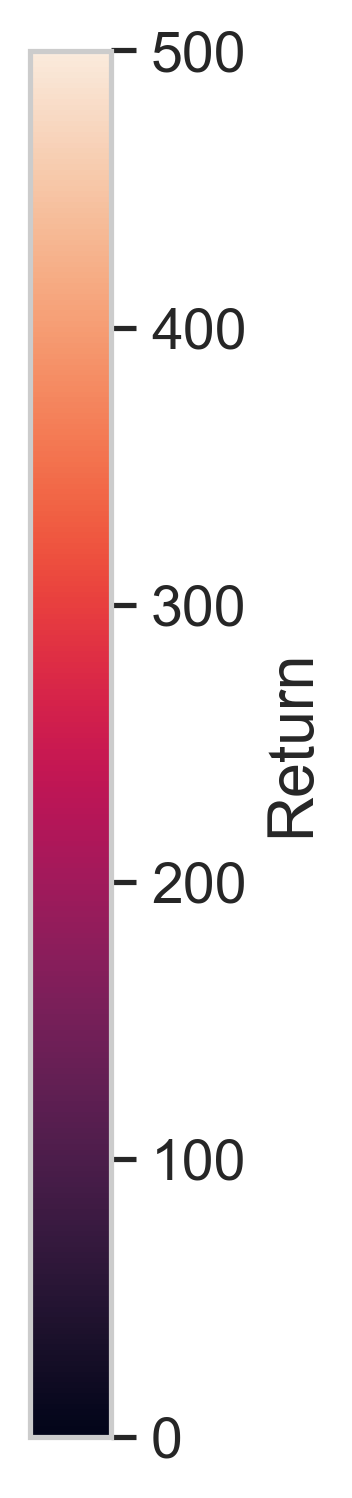

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set(font_scale=1.25)
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(0.35, 6), dpi=300)
# fig.subplots_adjust(bottom=0.5)

# cmap = mpl.cm.rocket
cmap = sns.color_palette("rocket", as_cmap=True)
norm = mpl.colors.Normalize(vmin=0, vmax=500)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label='Return')
fig.set_tight_layout(True)
fig_fn = outdir / "heatmap_cmap.pdf"
fig.savefig(fig_fn, bbox_inches="tight", dpi=300)